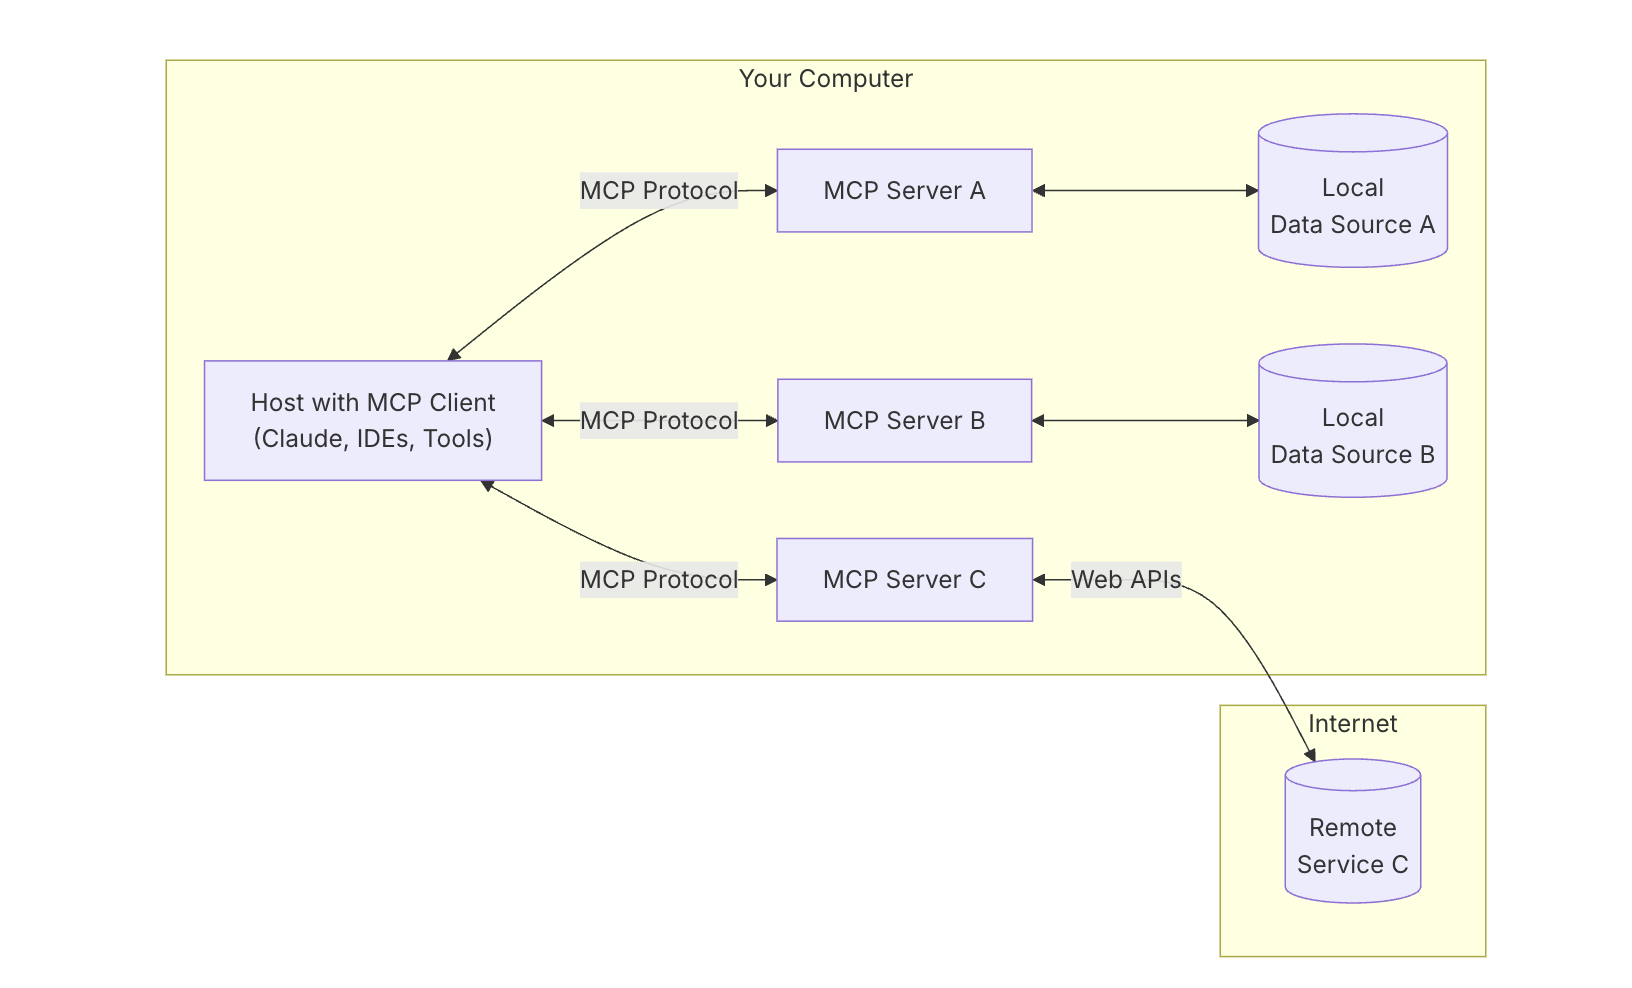

Anthropic's Model Context Protocol (MCP) is an open, standardized framework designed to connect AI models, particularly large language models (LLMs), seamlessly to various external data sources and tools. By providing standardized communication and integration methods, MCP simplifies the interaction between AI systems and their surrounding environments, reducing integration complexity and fragmentation

- MCP Hosts: Programs like Claude Desktop, IDEs, or AI tools that want to access data through MCP
- MCP Clients: Protocol clients that maintain 1:1 connections with servers
- MCP Servers: Lightweight programs that each expose specific capabilities through the standardized Model Context Protocol
- Local Data Sources: Your computer’s files, databases, and services that MCP servers can securely access
- Remote Services: External systems available over the internet (e.g., through APIs) that MCP servers can connect to

## Integrating MCP tools with AutoGen is straightforward. 
- The key component is the `mcp_server_tools` function, which bridges your agent with MCP servers. 
- Under the hood, `mcp_server_tools` implements an `McpToolAdapter` which inherits from the AutoGen `BaseTool` class. 
- This adapter leverages AutoGen's existing infrastructure for creating annotations and tool schemas, making the MCP tools seamlessly available to your agent.

In the example below, we will show how to use the MCP fetch server provided by the Anthropic team - A Model Context Protocol server that provides web content fetching capabilities.

In [1]:
import asyncio
from pathlib import Path
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from autogen_agentchat.ui import Console
from autogen_core.models import ModelInfo , UserMessage 
from autogen_ext.models.openai import OpenAIChatCompletionClient

from dotenv import load_dotenv
load_dotenv()
import yaml



Under the hood, mcp_server_tools does several important things:

- It wraps the MCP tool, extracting parameters so it can be used as a standard tool callable by any LLM

- It spins up an MCP client session based on the server parameters (in this case, "uvx mcp-server-fetch")

- It executes the server command, instantiates a client session, and runs list_tools to get the available tools schema

- It passes this schema to the agent, making the tools available for use



## summarize an article in the web using mcp_server_fetch

In [3]:
async def main() -> None:
    # Setup server params for local filesystem access
    fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
    tools = await mcp_server_tools(fetch_mcp_server)

    with open("model_config.yaml", "r") as f:
        model_config = yaml.safe_load(f)
    model_client = AzureOpenAIChatCompletionClient.load_component(model_config)
    agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)   

    await Console(agent.run_stream(task="Describe in detail the content of https://github.com/Arturo-Quiroga-MSFT/HEXAWARE", cancellation_token=CancellationToken()))
    
await main()

---------- TextMessage (user) ----------
Describe in detail the content of https://github.com/Arturo-Quiroga-MSFT/HEXAWARE
Describe in detail the content of https://github.com/Arturo-Quiroga-MSFT/HEXAWARE
---------- ToolCallRequestEvent (fetcher) ----------
[FunctionCall(id='call_36vUk0txq04bkuJT3isVrmX8', arguments='{"url":"https://github.com/Arturo-Quiroga-MSFT/HEXAWARE"}', name='fetch')]
---------- ToolCallExecutionEvent (fetcher) ----------
[FunctionExecutionResult(content='[{"type": "text", "text": "Contents of https://github.com/Arturo-Quiroga-MSFT/HEXAWARE:\\n## Azure AI Agent Service Technical Enablement for HEXAWARE\\n\\nThis repository provides technical enablement resources, code samples, and demonstrations for HEWARE, focusing on leveraging the Azure AI Agent Service. The goal is to help teams understand, implement, and extend AI agent capabilities using Azure\\u2019s powerful AI and cloud services.\\n\\n[![alt text](/Arturo-Quiroga-MSFT/HEXAWARE/raw/main/image.png)](/Artur

## Get web page contents and describe them with mcp_server_Fetch

In [4]:
async def main() -> None:
    # Setup server params for local filesystem access
    fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
    tools = await mcp_server_tools(fetch_mcp_server)

    with open("model_config.yaml", "r") as f:
        model_config = yaml.safe_load(f)
    model_client = AzureOpenAIChatCompletionClient.load_component(model_config)
    agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)   

    await Console(agent.run_stream(task="what are the main news in https:www.cnn.com", cancellation_token=CancellationToken()))
    
await main()

---------- TextMessage (user) ----------
what are the main news in https:www.cnn.com
what are the main news in https:www.cnn.com
---------- ToolCallRequestEvent (fetcher) ----------
[FunctionCall(id='call_vZGhNBi3kxIIVi4US7blc2f4', arguments='{"url":"https://www.cnn.com"}', name='fetch')]
---------- ToolCallExecutionEvent (fetcher) ----------
[FunctionExecutionResult(content='[{"type": "text", "text": "Contents of https://www.cnn.com/:\\n[Live Updates\\nIsrael-Iran conflict](/world/live-news/israel-iran-attacks-06-17-25-intl-hnk)\\n\\n[Sean \\u2018Diddy\\u2019 Combs trial](https://www.cnn.com/entertainment/live-news/diddy-trial-sean-combs-case-06-17-25)\\n\\n[Trending\\nStrait of Hormuz](/2025/06/17/business/israel-iran-oil-strait-of-hormuz)\\n\\n[Iran\\u2019s Fordow nuclear site](/2025/06/17/middleeast/iran-fordow-nuclear-site-latam-hnk-intl)\\n\\n[World\\u2019s best airline](/2025/06/17/travel/worlds-best-airline-2025-skytrax)\\n\\n[Eric Dane ALS](/2025/06/16/entertainment/eric-dane-

## interact with a locally hosted SLM (QWEN) to summarize web articles

In [6]:


qwen_model = OpenAIChatCompletionClient(
        model="Meta-Llama-3-8B-Instruct-GGUF",
        base_url="http://localhost:8080/v1",
        model_info=ModelInfo(vision=False, function_calling=True, json_output=False, family="unknown"),
        api_key="lm-studio",
    ) 
# Setup server params for local filesystem access
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
tools = await mcp_server_tools(fetch_mcp_server)

result = await qwen_model.create(messages=[UserMessage(source="user", content="Summarize the content of https://newsletter.victordibia.com/p/you-have-ai-fatigue-thats-why-you")], tools=tools)

print()
print(result.content)
print()



/Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/.venv/lib/python3.13/site-packages/autogen_ext/models/openai/_openai_client.py:413: UserWarning: Missing required field 'structured_output' in ModelInfo. This field will be required in a future version of AutoGen.
  validate_model_info(self._model_info)



The article "You Have AI Fatigue, That's Why You're Not Adopting AI" by Victor Bautista discusses the common phenomenon of "AI fatigue," which refers to the widespread feeling of being overwhelmed and unenthusiastic about adopting new AI technologies. The author argues that this is not because people are resistant to change or lack understanding of AI, but rather due to the following reasons:

1. **Information Overload**: There is too much information available about AI, making it difficult for individuals to know where to start and what's relevant.
2. **Lack of Personalization**: AI solutions are often presented as one-size-fits-all, failing to take into account individual needs and preferences.
3. **Fear of Job Replacement**: People may be hesitant to adopt AI-powered tools due to concerns about job security and the potential for automation to replace human jobs.
4. **Complexity**: AI can be complex and difficult to understand, leading to feelings of frustration and overwhelm.
5. **

/var/folders/dj/qp0fwj152ks28q9cn0_rd3fw0000gn/T/ipykernel_3323/966456818.py:11: UserWarning: Resolved model mismatch: Meta-Llama-3-8B-Instruct-GGUF != LM Studio Community/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to LM Studio Community/Meta-Llama-3-8B-Instruct-GGUF/Meta-Llama-3-8B-Instruct-Q4_K_M.gguf to enhance token/cost estimation and suppress this warning.
  result = await qwen_model.create(messages=[UserMessage(source="user", content="Summarize the content of https://newsletter.victordibia.com/p/you-have-ai-fatigue-thats-why-you")], tools=tools)
